# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# database
from sklearn.datasets import load_iris

%matplotlib inline
pd.options.display.max_rows = 10

# Introdução 

A ***Linear Discriminant Analsysis (LDA)*** é uma técnica muito utilizada para redução de dimensionalidade na etapa de pré-processamento em aplicações de reconhecimento de padrões e aprendizagem de máquina. **O objetivo é projetar o dataset em um espaço de menor dimensões com uma boa separação das classes para evitar overfitting e reduzir o custo computacional**.

A abordagem do LDA é bem semelhante a do PCA, no entanto, **além de encontrar os componentes que maximizam a variância dos nossos dados (PCA), nós também estamos interessados nos componentes que maximizam a separação entre múltiplas classes (LDA)**.

Resumindo, o objetivo do LDA é projetar um espaço de atributos (um banco de dados com amostras n-dimensional) em um subespaço menor ***k*** (onde $k \leq n-1$) mantendo a informação de discriminação das classes.

Em geral, a redução de dimensionalidade ajuda não somente a reduzir custos computacionais para um dado problema de classificação, mas também é útil para evitar o overfitting pela minimização do erro na estimação de parâmetros.

## PCA vs LDA

Ambos PCA e LDA são técnicas de transformações lineares bastante utilizadas para redução de dimensionalidade. Por um lado, o PCA pode ser descrito como um algoritmo "não-supervisionado", já que ele "ignora" os rótulos das classes e seu objetivo é encontrar as direções (componentes principais) que maximizam a variância no banco de dados. Por outro lado, o LDA é "supervisionado" e calcula as direções (discriminantes lineares) que vão representar os eixos que maximizam a separação entre múltiplas classes.

Embora pareça que o LDA seja superior ao PCA em problemas de multi-classificação onde os rótulos das classes são conhecidos, nem sempre isso acontece. Por exemplo, comparações entre acurácias de classificação para reconhecimento de imagens após o uso de PCA ou LDA mostra que **o PCA tende a ser melhor que o LDA se o número de amostras/classe é relativamente pequeno** (<a href="http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=908974">PCA vs LDA</a>, A.M. Martinez et al., 2001). Na prática, também é comum usar ambos LDA e PCA em conjunto, isto é, PCA para redução de dimensionalidade seguido por um LDA.

<img src="images/PCAvsLDA.png" width=600>



## O que é um "bom" subespaço?

Supondo que nosso objetivo é reduzir as dimensões de um dataset ***d***-dimensional pela projeção em um subespaço ***k***-dimensional (onde ***k < d***). Então, como saber qual tamanho devemos escolher para ***k*** (***k*** = o número de dimensões do novo subespaço de atributos), e como saber se nós temos um espaço de atributos que representa "bem" nossos dados?

Em breve, nós vamos calcular os autovetores (componentes) do nosso dataset e coletá-los em matrizes chamadas *matrizes-esparsas (scatter-matrizes)*, ou melhor, matrizes esparsas intra-classes e inter-classes. Cada um desses autovetores é associado a um autovalor que nos diz o "tamanho" ou "magnitude" dos autovetores.

**Se observamos que todos autovalores tem uma magnitude similar, então isso pode ser um bom indicador que nossos dados já estão projetados em um "bom" espaço de atributos.**

Por outro lado, se alguns autovalores tem a magnitude muito maior que a dos outros, devemos escolher seus autovetores já que eles contém mais informação sobre a distribuição dos nossos dados. Da mesma forma, autovalores próximos a zero são menos informativos e devemos desconsiderá-los na construção do nosso subespaço.

## Aplicação

Em geral, a aplicação do LDA envolve a aplicação dos seguintes passos:
1. Calcular a média (vetor **d**-dimensional) para cada uma das classes do dataset
2. Calcular as scatter-matrices (intra-classe e inter-classe)
3. Calcular os autovetores ($e_1, e_2, ..., e_d$) e seus correspondentes autovalores ($\lambda_1, \lambda_2,...\lambda_d$) para as scatter-matrices.
4. Ordenar os autovetores pelos autovalores em ordem decrescente e escolher os ***k*** autovetores com os maiores autovalores para formar uma matriz **W** [$d \times k$], onde cada coluna representa um autovetor.
5. Usar **W** para transformar as amostras no novo subespaço. Isso pode ser resumido pela multiplicação de matrizes: $Y = X \times W$ (onde **X** [$n \times d$] é a matriz que representa nosso dataset com ***n*** amostras, e **Y** é matriz das amostras transformadas no novo subespaço [$n \times k$]).

# Dataset

## Importando o Dataset

Nesse tutorial, vamos utilizar o **Iris dataset**, já presente no scikit-learn. O Iris dataset contém dados de 150 flores divididas em 3 espécies diferentes (setosa, versicolor, virginica). Os dados são:

1. sepal lenght em cm
2. sepal width em cm
3. petal length em cm
4. petal width em cm

<img src="images/Iris-dataset.png" width=400>

In [49]:
iris = load_iris()
print(iris.data.shape)
print(iris.target.shape)
print(iris.feature_names)
print(iris.target_names)

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
# df['class'] = df['class'].map({0:iris.target_names[0], 1:iris.target_names[1], 2:iris.target_names[2]})
df

(150, 4)
(150,)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [50]:
# split the data table into data X and class labels Y
x = df.ix[:, 0:4].values
y = df.ix[:, 4].values
print(x.shape, y.shape)

(150, 4) (150,)


## Data Analysis

In [41]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


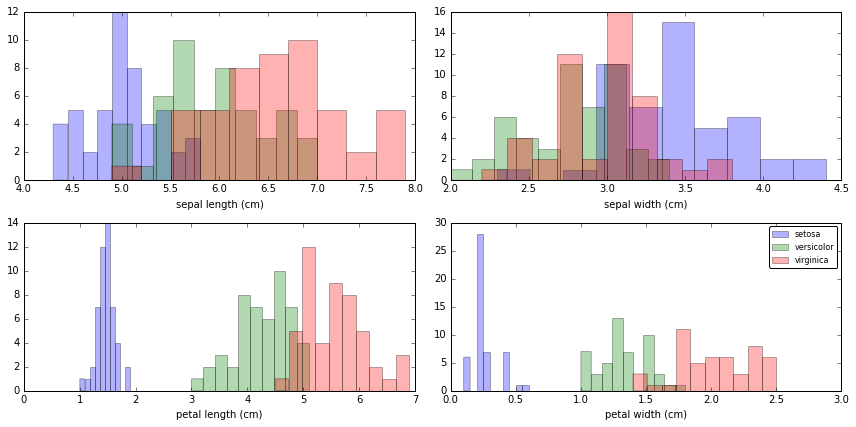

In [48]:
plt.figure(figsize=(12,6))
for f in range(4):
    plt.subplot(2, 2, f+1)
    for label in iris.target_names:
        plt.hist(x[y==label, f], label=label, bins=10, alpha=0.3)
        plt.xlabel(iris.feature_names[f])
plt.legend(loc='upper right', fancybox=True, fontsize=8)
plt.tight_layout()

Só de olhar para os gráficos, é fácil perceber que os atributos **petal length** e **petal width** são atributos potenciais para separar as flores pelas classes. Na prática, ao invés de reduzir a dimensionalidade via projeção (LDA), uma boa alternativa seria aplicar uma técnica de seleção de características.

## Suposições de Normalidade

Assim como outros algoritmos, o LDA assume que os dados são normalmente distribuidos, os atributos são estatisticamente independentes e matriz de covariância idênticas para cada classe. Entretanto, isso só se aplica ao LDA como classificador. Como redutor de dimensionalidade, o LDA também funciona razoavelmente bem se essas suposições forem violadas. E mesmo para tarefas de classificação o LDA pode ser robusto a distribuição dos dados:

> “linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)” <a href="http://link.springer.com/article/10.1007%2Fs10115-006-0013-y">(Tao Li, et al., 2006)</a>.

# Linear Discrimant Analysis

## Passo 1: Calcular os médios d-dimensionais

Vamos começar calculando os vetores médios **$m_i, i =(0,1,2)$** para as 3 classes de flores:

$$
\pmb m_i = \begin{bmatrix}
\mu_{\omega_i (\text{sepal length)}}\\
\mu_{\omega_i (\text{sepal width})}\\
\mu_{\omega_i (\text{petal length)}}\\
\mu_{\omega_i (\text{petal width})}\\
\end{bmatrix} \; , \quad \text{para} \quad i = 0,1,2
$$

In [6]:
mean_vectors = []
for c in range(0,3):
    mean_vectors.append(np.mean(x[y==c], axis=0))
    print('Mean vector class {0}: {1}'.format(c, mean_vectors[c]))

Mean vector class 0: [ 5.006  3.418  1.464  0.244]
Mean vector class 1: [ 5.936  2.77   4.26   1.326]
Mean vector class 2: [ 6.588  2.974  5.552  2.026]


## Passo 2: Calcular as Scatter Matrices

Agora vamos calcular as duas matrizes 4x4: intra-classe e entre-classes.

### Intra-classe scatter matrix $S_W$

A matriz scatter **intra-classe** $S_W$ é calculada pela seguinte equação:

$$S_W = \sum_{i=1}^{c}S_i$$

Onde,
$$S_i = \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T$$

e $m_i$ é o vetor médio.

In [7]:
S_W = np.zeros((4,4))
for c,mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in x[y == c]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('intra-classe scatter matrix:\n', S_W)

intra-classe scatter matrix:
 [[ 38.9562  13.683   24.614    5.6556]
 [ 13.683   17.035    8.12     4.9132]
 [ 24.614    8.12    27.22     6.2536]
 [  5.6556   4.9132   6.2536   6.1756]]


De forma alternativa, poderíamos calcula as matrizes de covariância adicionando um fator de escala $\frac{1}{N-1}$ a scatter matrix intra-classe, tão logo nossa equação passaria a ser:

$$\Sigma_i = \frac{1}{N_{i}-1} \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T$$

e

$$S_W = \sum\limits_{i=1}^{c} (N_{i}-1) \Sigma_i$$

onde $N_i$ é o tamanho da amostra para a classe respectivate (no nosso caso: 50), e nesse caso particular, poderíamos descartar o termo $(N_i-1)$ já que todas as classes tem o mesmo tamanho de amostra.

Entretanto, o autoespaçoes resultantes seriam os mesmos (mesmo autovetores, somente os autovalores seriam diferentemente escalados por um fator constante).

### Entre-classes scatter matrix $S_B$

A scatter matrix **entre-classes** $S_B$ é calculada pela seguinte equação:

$$S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb m_i - \pmb m) (\pmb m_i - \pmb m)^T$$

Onde **m** é a média geral, e $m_i$ e $N_i$ são as médias amostrais e tamanhos das respectivas classes.

In [8]:
overall_mean = np.mean(x, axis=0)

S_B = np.zeros((4,4))
for i, mean_vec in enumerate(mean_vectors):
    n = x[y==i,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('entre-classes scatter matrix:\n', S_B)

entre-classes scatter matrix:
 [[  63.21213333  -19.534       165.16466667   71.36306667]
 [ -19.534        10.9776      -56.0552      -22.4924    ]
 [ 165.16466667  -56.0552      436.64373333  186.90813333]
 [  71.36306667  -22.4924      186.90813333   80.60413333]]


## Passo 3: Cálculo dos autovalores para a matriz $S_W^{-1} S_B$

Agora, vamos calcular os autovalores para a matriz $S_W^{-1} S_B$ para obter os discriminantes lineares.

In [51]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)
    print('\nAutovetor {0}: \n{1}'.format(i+1, eigvec_sc.real))
    print('Autovalor {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Autovetor 1: 
[[ 0.20490976]
 [ 0.38714331]
 [-0.54648218]
 [-0.71378517]]
Autovalor 1: 3.23e+01

Autovetor 2: 
[[-0.00898234]
 [-0.58899857]
 [ 0.25428655]
 [-0.76703217]]
Autovalor 2: 2.78e-01

Autovetor 3: 
[[ 0.59203086]
 [-0.44694038]
 [-0.4812466 ]
 [ 0.46706045]]
Autovalor 3: 8.90e-16

Autovetor 4: 
[[-0.13637595]
 [ 0.3785031 ]
 [ 0.44310236]
 [-0.80112253]]
Autovalor 4: -7.13e-15


A título de recordação, ambos autovetore e autovalores nos dão informações a respeito da distorção em uma transformação linear: os **autovetores são basicamente a direção dessa distorção**, enquanto os **autovalores representam o fator de escala para os autovetores que descrevem a magnitude da distorção**.

Se estamos aplicando o LDA para redução de dimensionalidade, os autovetores são importantes uma vez que eles vão formar os novos eixos do novo subespaço de atributos; os autoalores associados são particularmente importantes pois nos dizem quão "informativos" os novos eixos são.

### Verificação dos autovetores e autovalores

Podemos verificar os nosso autovetores e autovalores calculados pela verificação da seguinte equação:

$$Av = \lambda v$$

onde,
$$A = S_W^{-1}S_B$$
$$v = autovetor$$
$$\lambda = autovalor$$

In [10]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    print(np.linalg.inv(S_W).dot(S_B).dot(eigv).T, (eig_vals[i]*eigv).T, sep='\n', end='\n\n')

[[  6.61283911  12.49387258 -17.63604981 -23.03524504]]
[[  6.61283911  12.49387258 -17.63604981 -23.03524504]]

[[-0.0024932  -0.16348649  0.07058152 -0.21290271]]
[[-0.0024932  -0.16348649  0.07058152 -0.21290271]]

[[ -1.33226763e-15   0.00000000e+00   4.44089210e-15   7.10542736e-15]]
[[  5.26679906e-16  -3.97605149e-16  -4.28124491e-16   4.15504276e-16]]

[[  4.21884749e-15   6.66133815e-15  -1.15463195e-14  -5.32907052e-15]]
[[  9.72108728e-16  -2.69802823e-15  -3.15850174e-15   5.71052446e-15]]



## Passo 4: Selecão dos discriminantes lineares

### Ordenando os autovetores pelos autovalores em ordem decrescente

Não estamos interessado em somente projetar os dados em um subespaço que aumenta a separação entre as classes, mas também reduzir a dimensionalidade do nosso espaço de atributos. Entretanto, os autovetores somente definem as direções dos novos eixos, já que todos são vetores unitários.

Logo, para decidir quai(s) autovetor(es) nós escolheremos, iremos olhar os autovalores correspondentes de cada autovetor. De maneira geral, vamos mantes os autovetores com os maiores autovalores associados a eles.

A maneira mais comum de fazer isso é ordenar os autovalores em ordem decrescente e escolher os top-k autovetores associados.

In [20]:
# Cria uma lista de tuplas (autovalor, autovetor)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordena o par em ordem decrescente
eig_pairs.sort()
eig_pairs.reverse()

print('Autovalores em ordem decrescente:')
for i in eig_pairs:
    print(i[0])

Autovalores em ordem decrescente:
32.2719577997
0.27756686384
7.1281536575e-15
8.89615625371e-16


Analisando os autovalores, podemos ver que 2 autovalores são próximos a zero. Isso acontece por que eles não carregam nenhuma informação associada. Na verdade, eles deveriam ser exatamente 0, mas não são por conta de imprecisão dos pontos-flutuantes. No LDA, o número de discriminantes lineares é no máximo $c-1$ onde **c** é o número de classes, já que a matriz esparsa entre-classes $S_B$ é a soma da **c** matrizes com rank 1 ou menos. Perceba que no caso raro de colinearidade perfeita (todos os pontos da amostra alinhados em linha reta), a matriz de covariâncai deveria ter rank 1, que resultaria em somente um autovetor com um autovalor diferente de zero.

Agora, vamos calcular a **variância explicada** em termos de porcentagem:

In [21]:
print('Variância explicada')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variância explicada
eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


O primeiro autopar é de longe o mais representativo, e não vamos perder muita informação se formamos um espaço 1D baseado nesse autopar.

### Escolhendo o *k* autovetores com os maiores autovalores

Depois de ordenar os autopares em ordem decrescente pelos autovalores, agora é hora de construir nosso matriz **W** de autovetores $k \times d$-dimensional (aqui: $4 \times 2$: escolhendo os 2 autopares mais informativos) e portanto reduzindo nosso espaço 4-dimensional inicial em um subespaço 2-dimensional.

In [22]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matriz W:', W.real, sep='\n')

Matriz W:
[[ 0.20490976 -0.00898234]
 [ 0.38714331 -0.58899857]
 [-0.54648218  0.25428655]
 [-0.71378517 -0.76703217]]


## Passo 5: Transformando as amostras no novo subespaço

Por último, vamos usar nossa matriz **W** (4x2) para transformar nossas amostras no novo subespaço através da equação:

$$Y = X \times W$$

onde,
- **X**: matriz $n \times d$ representando as *n* amostras
- **Y**: matriz transformada $n \times k$ das amostras no novo subespaço

In [27]:
X = x.dot(W)
X.shape

(150, 2)

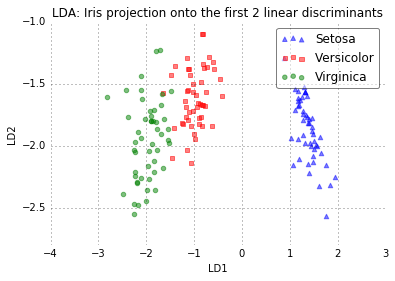

In [32]:
def plot_step_lda():
    label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}
    
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0].real[y == label],
                y=X[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

O gráfico acima representa nosso novo subespaço que construímos via LDA. Podemos ver que nosso primeiro discriminante linear "LD1" separa as classes de forma bem satisfatória. Entretanto, o segundo discriminante, "LD2", não adiciona muita informação útil, como vimos quando calculamos a variância explicada.

# Comparação entre PCA e LDA

Para comparar o subespaço de atributos que obtemos pelo LDA, vamos utilizar o <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA do scikit-learn</a>.

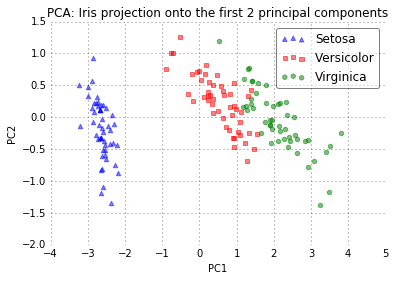

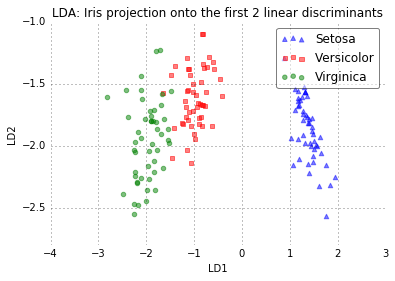

In [37]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(x)

def plot_pca():    
    label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}
    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()

plot_pca()
plot_step_lda()

# LDA via scikit-learn

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components=2)
x_lda_sklearn = sklearn_lda.fit_transform(x, y)

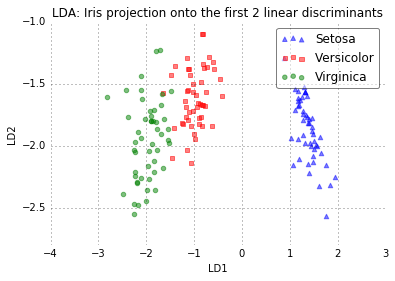

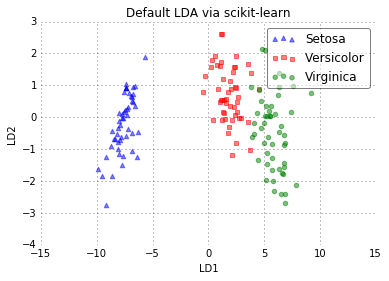

In [38]:
def plot_scikit_lda(X, title):
    label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()
plot_scikit_lda(x_lda_sklearn, title='Default LDA via scikit-learn')

# Nota sobre Standardization

O escalamento de atributos (como padronização) **não** afeta os resultados gerais de um LDA e, portanto, pode ser opcional. Obviamente, as matrizes scatter vão ser diferentes dependendo se os atributos foram normalizados ou não. Além disso, os autovetores vão ser diferentes também. Entretanto, a parte importante é que os autovalores vão ser exatamente os mesmos como também as projeções finais - a única diferença que você notará é a escala dos eixos. Isso pode ser mostrado matematicamente (trabalhos futuros) e você pode encontrar nas referências a demonstração prática.

# Referências

1. <a href="http://sebastianraschka.com/Articles/2014_python_lda.html">http://sebastianraschka.com/Articles/2014_python_lda.html</a>